## Simpsons Character Classification

Using deep neural networks to classify characters from the TV show 'The Simpsons'.  
The dataset used in this project is available as a download from Kaggle [https://www.kaggle.com/alexattia/the-simpsons-characters-dataset](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset).

PyTorch will be used to implement the neural network structures and training. 


In [1]:
# Load the required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torchvision
import torchvision.transforms as transforms

sns.set_style('darkgrid')

Load the data from the `./data` directory. Training and test data set are split and put into seperate directories `./data/train` and `./data/test`. Class labels are indicated by the folder name one level below, e.g. `./data/train/homer` for training images of Homer Simpson. 

To decrease the complexity of the classification task, we focus on a total 18 characters (labels). The characters include 

* Marge, Homer, Lisa, Bart, and Abe/Granpa Simpson
* Mr. Burns and Smithers
* Edna and Principle Skinner
* Chief Wiggum, Apu, Krusty the Clown
* Ned Flaners, Moe, Patty and Selma
* Milhouse and Nelson

Data is loaded and transformed into PyTorch tensors. To double the number of training images, we perform data augmentation by flipping the images horizontally.  
Images are initially cropped and resized to a shape of (64, 64).

In [2]:
# Hyperparameters for the training procedure
batch_size = 200
epochs = 25
learn_rate = 1e-3

# Use cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the data for the experiment
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.ImageFolder('./data/train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Map for labels, so that we can visualize the results better
label_map = {
    0: 'Apu', 1: 'Bart', 2: 'Mr. Burns', 3: 'Chief Wiggum', 4: 'Edna', 5: 'Abe',
    6: 'Homer', 7: 'Krusty', 8: 'Lisa', 9: 'Marge', 10: 'Milhouse', 11: 'Moe', 
    12: 'Flanders', 13: 'Nelson', 14: 'Patty', 15: 'Skinner', 16: 'Selma', 17: 'Smithers'
}

# Load test dataset 
test_dataset = torchvision.datasets.ImageFolder('./data/test', transform=transform)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

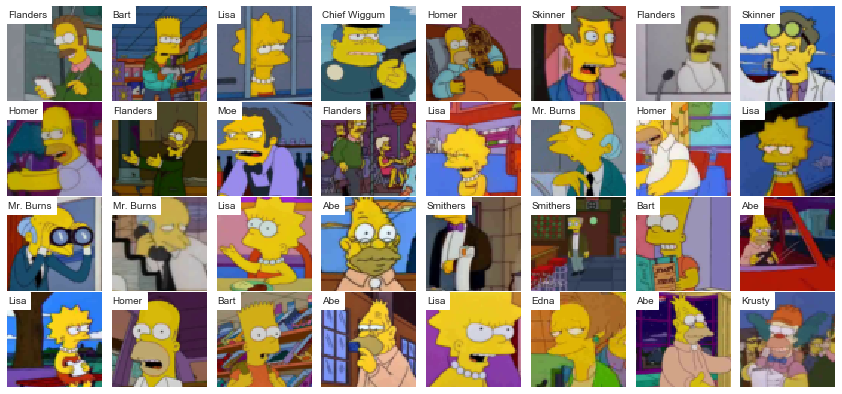

In [3]:
# Visualize some of the transformed training data
x, y = next(iter(dataloader))

# Remove normalization for correct display
x = x * 0.5 + 0.5

x = x.cpu().numpy()
y = y.cpu().numpy()

# Plot the data
plt.figure(figsize=(15, 7))
for i in range(8 * 4):
    plt.subplot(4, 8, i+1)
    plt.imshow(np.transpose(x[i], (1, 2, 0)))
    plt.axis('off')
    plt.text(0, 7, label_map[y[i]], bbox=dict(facecolor='white'))

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

## Setup the Model and Training

Load the deep convolutional neural network model, setup optimization function (cross-entropy) and optimizer.  

We then train the network for 10 eochs on the training data set. 

In [4]:
from models import ConvModel

model = ConvModel(channels=3, num_classes=18).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

print(model)

ConvModel(
  (conv_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
  )
  (fc_1): Linear(in_features=8192, out_features=512, bias=True)
  (fc_2): Linear(in_features=512, out_features=18, bias=True)
)


In [5]:
# Train the model for {epochs} epochs
iteration = 0

 # print loss and compute validation errer every {n} iternations
evaluate_every_n = 50

training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

for e in range(epochs):

    for (idx, data) in enumerate(dataloader):

        iteration += 1

        # Prepare batch data for this iteration
        data = data
        x, y = data
        x, y = x.to(device), y.to(device)

        # Train the model
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()


        # Log loss and compute validation error
        if iteration % evaluate_every_n == 0:
            # TODO: maybe look into some frameworks for evaluations with pytorch

            # Evaluate model on test data
            model.eval()

            # Load test data and compute loss
            (x_test, y_test) = next(iter(validation_loader))
            x_test, y_test = x_test.to(device), y_test.to(device)

            # Training error and accuracy
            y_pred = model(x)
            loss = criterion(y_pred, y)
            training_loss.append(loss.item())

            class_pred = torch.argmax(y_pred, dim=1)
            accuracy = class_pred.eq(y).sum().item() / batch_size
            training_accuracy.append(accuracy)

            # Validation error and accuracy
            y_test_pred = model(x_test)
            loss = criterion(y_test_pred, y_test)
            validation_loss.append(loss.item())

            class_test_pred = torch.argmax(y_test_pred, dim=1)
            accuracy = class_test_pred.eq(y_test).sum().item() / batch_size
            validation_accuracy.append(accuracy)


            # Switch model back to train mode
            model.train()
            print("Epoch {}/{}, Iteration {}/{} \t Train. Loss {:.3f}, Val. Loss {:.3f}, Train. Accuracy {:.2f}, Val. Accuracy {:.2f}".format(
                e, epochs, idx + 1, len(dataset) // batch_size, 
                training_loss[-1], validation_loss[-1],
                training_accuracy[-1], validation_accuracy[-1]
            ))
            running_loss = 0



Epoch 0/25, Iteration 50/86 	 Train. Loss 2.473, Val. Loss 2.937, Train. Accuracy 0.26, Val. Accuracy 0.17
Epoch 1/25, Iteration 14/86 	 Train. Loss 1.920, Val. Loss 2.416, Train. Accuracy 0.40, Val. Accuracy 0.28
Epoch 1/25, Iteration 64/86 	 Train. Loss 1.702, Val. Loss 2.294, Train. Accuracy 0.49, Val. Accuracy 0.34
Epoch 2/25, Iteration 28/86 	 Train. Loss 1.478, Val. Loss 1.937, Train. Accuracy 0.56, Val. Accuracy 0.43
Epoch 2/25, Iteration 78/86 	 Train. Loss 1.215, Val. Loss 1.656, Train. Accuracy 0.61, Val. Accuracy 0.49
Epoch 3/25, Iteration 42/86 	 Train. Loss 1.191, Val. Loss 1.412, Train. Accuracy 0.60, Val. Accuracy 0.58
Epoch 4/25, Iteration 6/86 	 Train. Loss 0.822, Val. Loss 1.311, Train. Accuracy 0.75, Val. Accuracy 0.60
Epoch 4/25, Iteration 56/86 	 Train. Loss 0.879, Val. Loss 1.164, Train. Accuracy 0.72, Val. Accuracy 0.62
Epoch 5/25, Iteration 20/86 	 Train. Loss 0.698, Val. Loss 1.129, Train. Accuracy 0.78, Val. Accuracy 0.66
Epoch 5/25, Iteration 70/86 	 Train. L

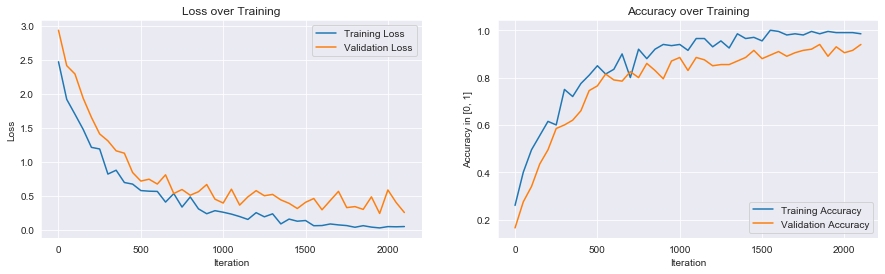

In [6]:
# Visualizing the loss over the duration of training
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(np.arange(0, len(training_loss)) * evaluate_every_n, training_loss)
plt.plot(np.arange(0, len(training_loss)) * evaluate_every_n, validation_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Loss over Training')
plt.ylabel('Loss')
plt.xlabel('Iteration')

plt.subplot(122)
plt.plot(np.arange(0, len(training_accuracy)) * evaluate_every_n, training_accuracy)
plt.plot(np.arange(0, len(validation_accuracy)) * evaluate_every_n, validation_accuracy)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title('Accuracy over Training')
plt.ylabel('Accuracy in [0, 1]')
plt.xlabel('Iteration');


In [7]:
# Save the model for later predicting 
state_dict = model.state_dict()
torch.save(state_dict, './model/weights.pt')

In [51]:
# Load the saved model in case you want to skip the training
model.load_state_dict(torch.load('./model/weights.pt'))

<All keys matched successfully>

## Predict with the Trained Model

Predicting the Simpsons character in images of the test set. The model is able to predict the correct class/character in all test images. 

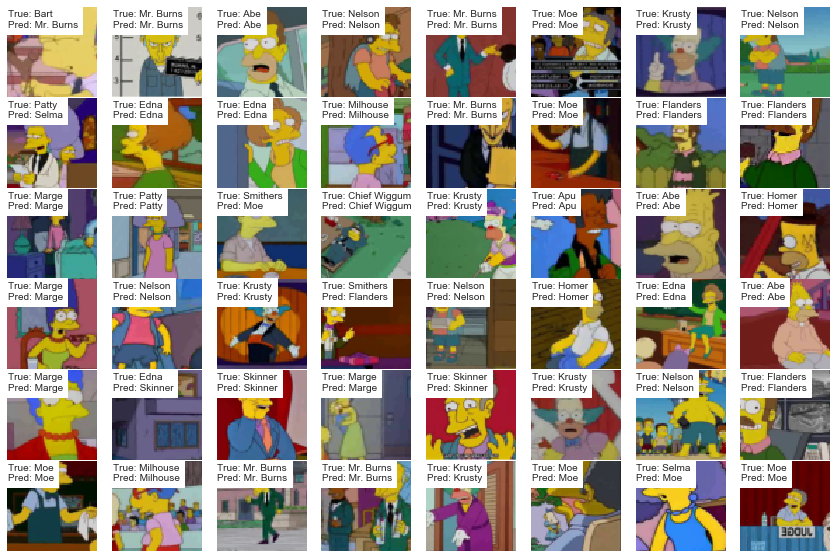

In [8]:

model.eval()
x, y = next(iter(validation_loader))
x = x.to(device)

# Predict the class of the image

probs = model(x)
y_pred = torch.argmax(probs, dim=1).cpu().numpy()

# Remove normalization for correct display
x = x * 0.5 + 0.5

x = x.cpu().numpy()
y = y.cpu().numpy()

# Plot the data
plt.figure(figsize=(15, 10))
for i in range(8 * 6):
    plt.subplot(6, 8, i+1)
    plt.imshow(np.transpose(x[i], (1, 2, 0)))
    plt.axis('off')
    label_str = f"True: {label_map[y[i]]}\nPred: {label_map[y_pred[i]]}"
    plt.text(0, 14, label_str, bbox=dict(facecolor='white'))

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

## Statistics Report

Extendend and detailed statistics for the trained model. 
 
The classification report contains information about:   
* __Precision__: = $\frac{TP}{TP + FP}$, where TP = True Positive, FP = False Positive.
* __Recall__: = $\frac{TP}{TP + FN}$, where FN = False Negative.
* __F1-Score__: Harmonic mean between precision and recall. 
* __Support__: Indicates the number of elements with class $y_i$ in the dataset. 

In [9]:
# we use sklearn to get the classification report and confussion matrix
import sklearn.metrics as metrics
model.eval()

# Load all test data simultaneously
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
x_test, y_test = next(iter(validation_loader))
x_test, y_test = x_test.to(device), y_test.to(device)

# Predict with trained model
probs = model(x_test)
y_pred = torch.argmax(probs, dim=1)

# For further analysis convert all data to numpy
y_test = y_test.cpu().numpy()
y_pred = y_pred.cpu().numpy()

print(metrics.classification_report(y_test, y_pred, target_names=label_map.values()))

precision    recall  f1-score   support

         Apu       1.00      1.00      1.00        50
        Bart       0.98      0.96      0.97        50
   Mr. Burns       0.81      0.98      0.89        48
Chief Wiggum       0.98      1.00      0.99        50
        Edna       1.00      0.96      0.98        50
         Abe       1.00      1.00      1.00        48
       Homer       0.94      1.00      0.97        50
      Krusty       1.00      0.96      0.98        50
        Lisa       0.89      0.98      0.93        50
       Marge       0.93      1.00      0.96        50
    Milhouse       0.94      1.00      0.97        49
         Moe       0.72      1.00      0.84        50
    Flanders       0.98      1.00      0.99        49
      Nelson       1.00      1.00      1.00        50
       Patty       0.81      0.46      0.59        37
     Skinner       0.87      0.96      0.91        50
       Selma       0.68      0.60      0.64        35
    Smithers       1.00      0.42      0.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text xticklabel objects>)

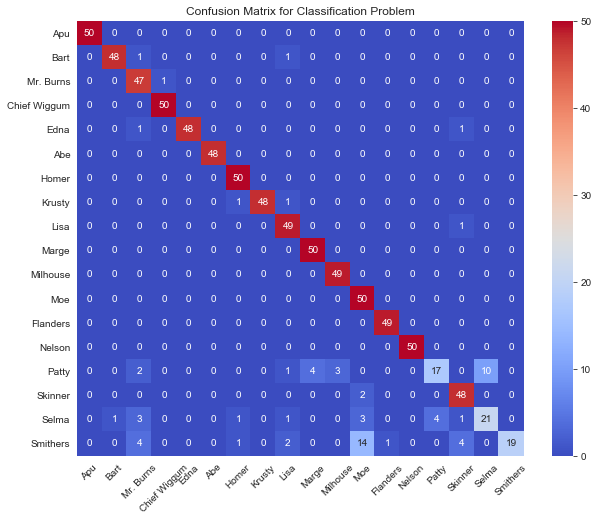

In [10]:
# Create and plot a confussion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', 
    xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title("Confusion Matrix for Classification Problem")
plt.xticks(rotation=45)

Based on the results in the confusion we can see that the model is able to predict the class for a majority of the images with high accuracy.  
The model has trouble correctly predicting the results for Selma and Patty (their design looks pretty similar though...), as well as the character Smithers, who is often categorized as, either, Mr. Burns or Moe. 

Number of wrong classifications: 70, at [ 94  99 107 203 220 374 393 438 694 699 701 705 706 707 709 710 712 713
 714 715 716 718 719 720 724 728 729 730 731 758 784 786 787 792 794 799
 800 801 802 803 808 812 814 815 818 820 823 824 826 827 828 829 831 832
 834 837 838 839 842 843 844 845 847 848 849 850 851 852 853 855]
(70, 3, 64, 64)


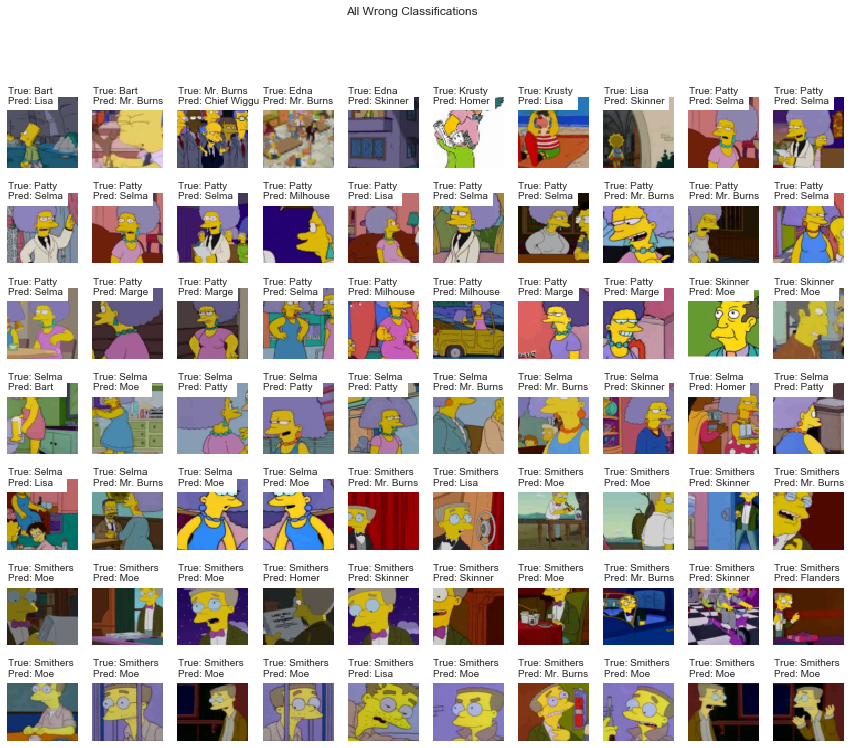

In [13]:
# Visualize incorrectly classified images
not_equal = np.not_equal(y_test, y_pred)
indexes = np.argwhere(not_equal == True).flatten()
print(f"Number of wrong classifications: {len(indexes)}, at {indexes}")
x = x_test.cpu().numpy()
x = x[indexes]
x = x * 0.5 + 0.5
print(x.shape)

plt.figure(figsize=(15, 12))
for i in range(7 * 10):
    plt.subplot(7, 10, i+1)
    plt.suptitle('All Wrong Classifications')
    plt.imshow(np.transpose(x[i], (1, 2, 0)))
    plt.axis('off')
    label_str = f"True: {label_map[y_test[indexes[i]]]}\nPred: {label_map[y_pred[indexes[i]]]}"
    plt.text(0, 5, label_str, bbox=dict(facecolor='white'))

